In [33]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit_aqua import Operator, run_algorithm
from qiskit_aqua.input import EnergyInput
from qiskit_aqua.translators.ising import maxcut, tsp
from qiskit_aqua.algorithms import VQE, ExactEigensolver
from qiskit_aqua.components.optimizers import SPSA
from qiskit_aqua.components.variational_forms import RY,RYRZ
from qiskit_aqua import QuantumInstance
from qiskit_aqua.components.optimizers import NELDER_MEAD, CG, COBYLA

import pylab
import numpy as np
from qiskit import Aer
from qiskit import LegacySimulators
from qiskit_aqua import run_algorithm
from qiskit_aqua.algorithms import Grover
from qiskit_aqua.components.oracles import SAT

import time

# setup aqua logging
import logging
from qiskit_aqua import set_aqua_logging

# Demo: The Hamiltonian Cycle Problem

The Hamiltonian Cycle problem is the problem of given a graph $G(V,E)$, output 1 iff there exists a cycle $c$ in $G$ such that $c$ visits each node exactly once. Otherwise, it outputs zero.

### Generating the Graph

First, let us generate a random graph on which to solve the problem

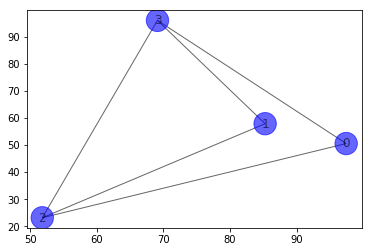

In [22]:
# Generating a random graph for Hamiltonian Cycle
n = 4
num_qubits = n ** 2

# generate a random graph using the built-in TSP function
temp = tsp.random_tsp(n)
coords = temp.coord

# An edge is considered an edge if it has wieght > 35 (arbitarily chosen)
edges = [x > 40 for x in temp.w]

# Add nodes and edges
G = nx.Graph()
G.add_nodes_from(range(n))
for i in range(n):
    for k in range(i,n):
        if edges[i][k]:
            G.add_edge(i,k,color="black",weight=1)
            
# Draw the graph
colors = ['b' for _ in range(n)]
pos = {k: v for k,v in enumerate(coords)}
default_axes = plt.axes(frameon = True)
nx.draw_networkx(G, node_color=colors, node_size=500, alpha=.6, ax=default_axes, pos=pos)

# Brute Force Solution

Here, we simply iterate over all possible permutations of the nodes of the graph. Then, we check whether or not this particular ordering of the nodes is actually a valid cycle (i.e. whether or not all the edges between those nodes exist in the graph). If the permutation is a valid Hamiltonian cycle, then we output True and return that permutation. If not, then we keep going until we finish all possible permutation. If we don't return by the end of the loop, then no possible permutations of the graph nodes make a Hamiltonian cycle, so we output False.

In [23]:
from itertools import permutations

In [24]:
def brute_force_solution(N, edges):
    #loop over all possible permutations
    perms = list(permutations(range(1,N)))
    for perm in perms:
        valid = True
        pre_j = 0
        for j in perm:
            # if the edge doesn't exist, then not a valid cycle
            if not edges[pre_j][j]:
                valid=False
                break
            pre_j = j
        if not edges[pre_j][0]:
            valid = False
        # Found a valid cycle!
        if valid:
            return True, (0,)+perm
    # No Hamiltonian cycle :(
    return False

start = time.time()
# Find the result of the brute force approach on the produced graph G
result_classical_brute = brute_force_solution(n, edges)
order1 = result_classical_brute[1] if result_classical_brute[1] else None
if not result_classical_brute:
    print("There was no Hamiltonian cycle found.")
else:
    print("A Hamiltonian cycle was found! The cycle found was ", result_classical_brute[1])
end = time.time()
classical_time = (end-start)

A Hamiltonian cycle was found! The cycle found was  (0, 2, 1, 3)


### Drawing the result!

We represent the Hamiltonian cycle that we found by red bold edges.

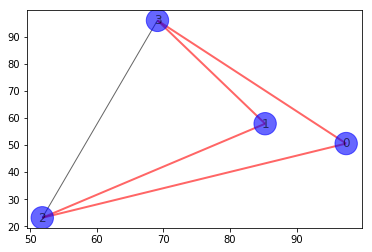

In [25]:
# A general drawing function for any solution
def draw_solution(G, order, colors, pos):
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2[order[i]][order[j]]['color'] = 'red'
        G2[order[i]][order[j]]['weight']=2
    edge_color = [G2[u][v]['color'] for u,v in G2.edges()]
    edge_weight = [G2[u][v]['weight'] for u,v in G2.edges()]
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color=edge_color, width=edge_weight, node_size=500, alpha=.6, ax=default_axes, pos=pos)

draw_solution(G, order1, colors, pos)

# Using VQE!

We know now that we can solve the Hamiltonian Cycle problem by brute force, but that takes exponential time and that's sad and lame. Let's use the magic of Quantum Physics! One way would be to use VQE. While we could try and emulate an Ising Hamiltonian whose zero energy eigenvector matches the result of the problem, an easier way of going about this, would be to simply reduce the Hamiltonian Cycle problem to a more familiar problem that we already know how to compute using VQE. Luckily, we can show that the Hamiltonian Cycle problem reduced to the Traveling Salesman Problem (TSP)! In order to map HCP to TSP, we simply turn the HCP graph from an unweighted graph to a weighted graph. We create a new graph $G'(V',E')$, which has exactly the same nodes as $G$, $V' = V$. However, in $G'$, all the nodes are connected to each other. Then, for each edge $(i,j) \in E$, we give $w(i,j) \in E' = 1$, and for every $(i,j) \notin E$, we give $w(i,j) \in E' = 2$.

Therefore, for us to know $HCP(G)$, we calculate $TSP(G', n)$. If $TSP(G', n) = 1$, then $HCP(G, n)$ = 1. Otherwise, $HCP(G, n) = 0$.

## Exact Eigensolver

We start by proving this concept and that it works by running our reduction Ising Hamiltonian through an exact eigensolver and checking that the produced result is in fact a Hamiltonian Cycle of the graph.

In [26]:
def vqe_exact_solution(N, edges):
    # get coordinates, they really don't matter
    coords = [i for i in range(N)]
    
    # Produces weights, 1 if (i,j) in E, 2 otherwise
    w = np.array([np.array([0 if i == j else (1 if edges[i][j] else 2) for i in range(N)]) for j in range(N)])
    
    # produce the TSP Object
    tsp_obj = tsp.TspData(name='tmp',dim=N, coord=coords,w=w)
    
    # Solve TSP
    qubitOp, offset = tsp.get_tsp_qubitops(tsp_obj)
    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()
    x = tsp.sample_most_likely(result['eigvecs'][0])
    order = tsp.get_tsp_solution(x)
    distance = tsp.tsp_value(order, w)
    
    # Check the result is equal to n, therefore we have a Hamiltonian Cycle
    if distance != n:
        return False, result
    else:
        return True, order, result

In [27]:
start = time.time()
vqe_exact_result = vqe_exact_solution(n, edges)
end = time.time()
vqe_exact_time = end-start

In [28]:
order_vqe_exact = vqe_exact_result[1] if vqe_exact_result[1] else None
if not vqe_exact_result[0]:
    print("There was no Hamiltonian cycle found.")
else:
    print("A Hamiltonian cycle was found! The cycle found was ", order_vqe_exact)

A Hamiltonian cycle was found! The cycle found was  [3, 0, 2, 1]


### Drawing the Graph!

By drawing the solution from the exact solver of the VQE, we see that this is in fact a Hamiltonian Cycle, and in fact the same cycle that we found classically using the brute force approach!

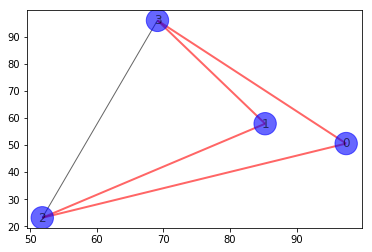

In [29]:
draw_solution(G, order_vqe_exact, colors, pos)

## Simulating a Quantum Device VQE!

Now that we know that our reduction works and we have proven the concept, let's now try and run it on a Quantum Device! We run it on a $\texttt{statevector_simulator}$ provided by Qiskit Aer and check that we get the right result!

In [16]:
def vqe_simulator(N, edges):
    coords = [i for i in range(N)]
    w = np.array([np.array([0 if i == j else (1 if edges[i][j] else 2) for i in range(N)]) for j in range(N)])
    tsp_obj = tsp.TspData(name='tmp',dim=N, coord=coords,w=w)
    seed = 10598
    qubitOp, offset = tsp.get_tsp_qubitops(tsp_obj)
    var_form = RY(num_qubits=qubitOp.num_qubits, depth=5, entanglement = "linear")
    opt = SPSA(max_trials=300)
    backend = Aer.get_backend('statevector_simulator')
    quantum_instance = QuantumInstance(backend=backend, seed=seed, seed_mapper=seed)
    vqe = VQE(qubitOp, var_form, opt, 'matrix')
    result = vqe.run(quantum_instance)
    x = tsp.sample_most_likely(result['eigvecs'][0])
    order = tsp.get_tsp_solution(x)
    distance = tsp.tsp_value(order, w)
    if distance != n:
        return False, result
    else:
        return True, order, result

In [17]:
vqe_simulator_result = vqe_simulator(n, edges)

/usr/share/anaconda3/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning
/usr/share/anaconda3/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [ ]:
vqe_simulator_result

In [18]:
order_vqe_simulator = vqe_simulator_result[1] if vqe_simulator_result[1] else None
if not vqe_simulator_result[0]:
    print("There was no Hamiltonian cycle found.")
else:
    print("A Hamiltonian cycle was found! The cycle found was ", order_vqe_simulator)
vqe_simulator_time = vqe_simulator_result[2]['eval_time']

A Hamiltonian cycle was found! The cycle found was  [2, 1, 0]


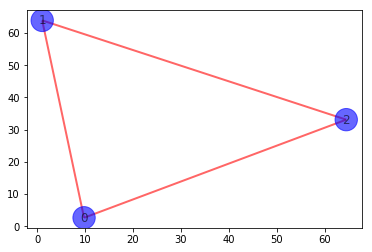

In [19]:
draw_solution(G, order_vqe_simulator, colors, pos)

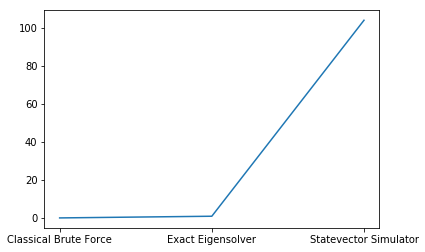

In [30]:
x = ["Classical Brute Force", "Exact Eigensolver", "Statevector Simulator"]
y = [classical_time, vqe_exact_time, vqe_simulator_time]
plt.plot(x,y)

# Using Grover's Algorithm!

We have shown that we can use reduction and built-in Qiskit functions for solving $TSP$ to be able to solve $HCF$! Now, we extend this principle and apply it to the $SAT$ problem and Grover's algorithm! One way of using Grover's algorithm to solve for $HCF$ would be to construct an entire oracle from scracth which is specifically designed for $HCF$. However, similar to the same principle we used earlier, we can instead use a classical reduction to a problem that we already have the Grover's oracle for. In this project, we reduce $HCF$ to the $SAT$ problem and use the built-in $SAT$ oracle for Grover's algorith provided by Qiskit.

## Reduction

We use a reduction $HCF \leq_p SAT$ for this problem. We reduce a $HCF$ problem to a $SAT$ problem by having 5 different sets of clauses, each to guarantee a different constraint of the $HCF$ problem. Together, they form all the constraints we need to solve the full problem. In this problem, we represent it as a $SAT$ CNF formula by using $n^2$ different variables, $x_{i,j}$, $1 \leq i,j \leq n$, such that $x_{i,j}=1$ iff node $j$ is at position $i$ in the Hamiltonian cycle. Otherwise, $x_{i,j} = 0$. We then introduce different contraints on these variables to guarantee:

1. Each node $j$ must appear at least once in the Hamiltonian path

2. Each node $j$ cannot appear more than once in the Hamiltonian path

3. Every position $i$ in the Hamiltonian cycle must be occupied by one node

4. No two nodes $j$ and $k$ can occupy the same position $i$.

5. Nodes $j$ and $k$ that are connected in the graph $G$ cannot be connected in the Hamiltonian cycle.

In [31]:
def reduction(n, edges):
    def varnum(i,j):
        return (i-1)*n+j
    num_clauses = 0
    sat_cnf=''
    # each node must appear once in the path
    nodes = range(1,n+1)
    for j in nodes:
        sat_cnf += ' '.join([str(varnum(i,j)) for i in nodes]) + ' 0\n'
        num_clauses += 1
    # no node appears twice in the path
    for j in nodes:
        for i in nodes:
            for k in nodes:
                if i != k:
                    sat_cnf += str(-varnum(i,j)) + ' ' + str(-varnum(k,j)) + ' 0\n'
                    num_clauses += 1
    # every position must be occupied
    for i in nodes:
        sat_cnf += ' '.join([str(varnum(i,j)) for j in nodes]) + ' 0\n'
        num_clauses += 1
    # no two nodes occupy the same position in the path
    for i in nodes:
        for j in nodes:
            for k in nodes:
                if j != k:
                    sat_cnf += str(-varnum(i,j)) + ' ' + str(-varnum(i,k)) + ' 0\n'
                    num_clauses += 1
    # Non adjacent nodes can't be adjacent in the path
    for i in nodes:
        for j in nodes:
            if not edges[i-1][j-1]:
                for k in range(1,n):
                    sat_cnf += str(-varnum(k,i)) + ' ' + str(-varnum(k+1,j)) + ' 0\n' 
                    num_clauses += 1
    sat_cnf = 'p cnf '+str(n**2)+' '+ str(num_clauses)+'\n'+sat_cnf
    return sat_cnf

### Reduced CNF Formula

In [32]:
sat_cnf = reduction(4, edges)
print(sat_cnf)

p cnf 16 122
1 5 9 13 0
2 6 10 14 0
3 7 11 15 0
4 8 12 16 0
-1 -5 0
-1 -9 0
-1 -13 0
-5 -1 0
-5 -9 0
-5 -13 0
-9 -1 0
-9 -5 0
-9 -13 0
-13 -1 0
-13 -5 0
-13 -9 0
-2 -6 0
-2 -10 0
-2 -14 0
-6 -2 0
-6 -10 0
-6 -14 0
-10 -2 0
-10 -6 0
-10 -14 0
-14 -2 0
-14 -6 0
-14 -10 0
-3 -7 0
-3 -11 0
-3 -15 0
-7 -3 0
-7 -11 0
-7 -15 0
-11 -3 0
-11 -7 0
-11 -15 0
-15 -3 0
-15 -7 0
-15 -11 0
-4 -8 0
-4 -12 0
-4 -16 0
-8 -4 0
-8 -12 0
-8 -16 0
-12 -4 0
-12 -8 0
-12 -16 0
-16 -4 0
-16 -8 0
-16 -12 0
1 2 3 4 0
5 6 7 8 0
9 10 11 12 0
13 14 15 16 0
-1 -2 0
-1 -3 0
-1 -4 0
-2 -1 0
-2 -3 0
-2 -4 0
-3 -1 0
-3 -2 0
-3 -4 0
-4 -1 0
-4 -2 0
-4 -3 0
-5 -6 0
-5 -7 0
-5 -8 0
-6 -5 0
-6 -7 0
-6 -8 0
-7 -5 0
-7 -6 0
-7 -8 0
-8 -5 0
-8 -6 0
-8 -7 0
-9 -10 0
-9 -11 0
-9 -12 0
-10 -9 0
-10 -11 0
-10 -12 0
-11 -9 0
-11 -10 0
-11 -12 0
-12 -9 0
-12 -10 0
-12 -11 0
-13 -14 0
-13 -15 0
-13 -16 0
-14 -13 0
-14 -15 0
-14 -16 0
-15 -13 0
-15 -14 0
-15 -16 0
-16 -13 0
-16 -14 0
-16 -15 0
-1 -5 0
-5 -9 0
-9 -13 0
-1 -6 0
-5 -10 0

## Running Grover's on $SAT$ CNF Formula

We define a function that computes the solution to the $SAT$ CNF Formula using the built-in oracle for Grover's algorithm.

In [ ]:
def SAT_Grover(sat_cnf, backend, shots):
    sat_oracle = SAT(sat_cnf)
    grover = Grover(sat_oracle)
    backend=Aer.get_backend(backend)
    quantum_instance = QuantumInstance(backend, shots=shots)
    result = grover.run(quantum_instance)
    return result['result']

In [ ]:
SAT_Grover(sat_cnf, 'qasm_simulator', 100)

Ideally, this would have solved our problem using Grover's algorithm. However, while the reduction is still polynomial, it is still quite expensive in terms of overhead, especially on the scale of current quantum computers. To solve the $SAT$ Formula for our graph, we would need 265 qubits, while the greatest number of qubits, even simulated, we have access to is 23. This goes to show how young and underdeveloped this area of scientific research is, and how much more work still needs to be done for any viable and practical pplication of Quantum Computing to be available to the masses.